In [1]:
import os, sys

os.chdir('Petreanu_MEI_generation')
sys.path.append(os.getcwd())

print(os.getcwd())

d:\Python\Anastasia\Petreanu Lab\Petreanu_MEI_generation


In [2]:
MEI_validation_session = [['LPE13959', '2025_02_19']]
MEI_validation_session_input_folder = 'D:/Procdata/IM'

In [3]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
from sensorium.utility.training import read_config
from sensorium.utility import submission
from nnfabrik.builder import get_data, get_model
from sensorium.models.ensemble import EnsemblePrediction
from sensorium.utility import get_correlations
from sensorium.utility.measure_helpers import get_df_for_scores
from loaddata.session_info import load_sessions
from utils.plotting_style import *  # get all the fixed color schemes
from utils.imagelib import load_natural_images
from loaddata.get_data_folder import get_local_drive
from utils.pair_lib import compute_pairwise_anatomical_distance
from utils.rf_lib import *
import pickle as pkl

# Set working directory to root of repo
current_path = os.getcwd()
# Identify if path has 'molanalysis' as a folder in it
if 'Petreanu_MEI_generation' in current_path:
    # If so, set the path to the root of the repo
    current_path = current_path.split('Petreanu_MEI_generation')[0] + 'Petreanu_MEI_generation'
else:
    raise FileNotFoundError(
        f'This needs to be run somewhere from within the Petreanu_MEI_generation folder, not {current_path}')
os.chdir(current_path)
sys.path.append(current_path)

print('Working directory:', os.getcwd())

run_config = read_config('run_config.yaml') # Must be set

RUN_NAME = run_config['current_vals']['RUN_NAME'] # MUST be set. Creates a subfolder in the runs folder with this name, containing data, saved models, etc. IMPORTANT: all values in this folder WILL be deleted.
RUN_FOLDER = run_config['current_vals']['RUN_FOLDER']
area_of_interest = run_config['current_vals']['data']['area_of_interest']
INPUT_FOLDER = run_config['data']['INPUT_FOLDER']
sessions_to_keep = run_config['data']['sessions_to_keep']
num_models = run_config['dev']['num_models']

print(f'Starting evaluation for {RUN_NAME} with area of interest {area_of_interest}')

warnings.filterwarnings('ignore')
# ### Load configuration for model

# Loading config only for ensemble 0, because all 5 models have the same config (except
# for the seed and dataloader train/validation split)

config_file = f'{RUN_FOLDER}/config_m4_ens0/config.yaml'
config = read_config(config_file)
config['model_config']['data_path'] = f'{RUN_FOLDER}/data'
print(config)
# ### Prepare dataloader

# Use only one dataloader, since test and final_test are the same for all ensembles
# basepath = "notebooks/data/"
# filenames = [os.path.join(basepath, file) for file in os.listdir(basepath) if ".zip" in file ]
# filenames = [file for file in filenames if 'static26872-17-20' not in file]

basepath = f'{RUN_FOLDER}/data'
# Add Add folders two levels deep from basepath into a list
# First level
folders = [os.path.join(basepath, name) for name in os.listdir(
    basepath) if os.path.isdir(os.path.join(basepath, name)) and not "merged_data" in name]
# Second level
folders = [os.path.join(folder, name) for folder in folders for name in os.listdir(
    folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
folders = [x.replace("\\", "/") for x in folders]
print(folders)

Working directory: d:\Python\Anastasia\Petreanu Lab\Petreanu_MEI_generation
Starting evaluation for V1_MEI_in_vivo_validation_without_grid_mean_predictor with area of interest V1
{'data_sets': ['all'], 'dataset_fn': 'sensorium.datasets.static_loaders', 'dataset_config': {'normalize': True, 'include_behavior': True, 'include_eye_position': True, 'batch_size': 128, 'scale': 0.25, 'preload_from_merged_data': True, 'include_trial_id': True, 'include_rank_id': True, 'include_history': True, 'include_behav_state': True, 'adjusted_normalization': True, 'use_ensemble_tier': True, 'ensemble_nr': 0}, 'model_fn': 'sensorium.models.modulated_stacked_core_full_gauss_readout', 'model_seed': 100, 'model_config': {'pad_input': False, 'stack': -1, 'layers': 4, 'input_kern': 9, 'gamma_input': 9.8, 'gamma_readout': 0.48, 'hidden_kern': 10, 'hidden_channels': 64, 'depth_separable': True, 'grid_mean_predictor': None, 'init_sigma': 0.14, 'init_mu_range': 0.8, 'gauss_type': 'full', 'max_jitter': 0, 'max_jitt

In [4]:
try: 
    session_folders
except NameError:
    # First level
    session_folders = [os.path.join(INPUT_FOLDER, name) for name in os.listdir(
        INPUT_FOLDER) if os.path.isdir(os.path.join(INPUT_FOLDER, name)) and not "merged_data" in name]
    session_folders = [x.replace("\\", "/") for x in session_folders]
    # Second level
    files = [[session_folder, os.path.join(session_folder, name).replace('\\', '/')] for session_folder in session_folders for name in os.listdir(
        session_folder) if os.path.isdir(os.path.join(session_folder, name)) and not "merged_data" in name]
    # only get last value after /
    session_list = [[session_folder.split("/")[-1], name.split("/")[-1]]
                    for session_folder, name in files]

    # drop ['LPE10919', '2023_11_08'] because the data is not converted yet
    session_list = [x for x in session_list if x != ['LPE10919', '2023_11_08']]

if sessions_to_keep != 'all':
    session_list = [x for x in session_list if x in sessions_to_keep]

session_list = np.array(session_list)

print(session_list)

[['LPE09665' '2023_03_20']
 ['LPE10883' '2023_10_23']
 ['LPE10883' '2023_10_31']
 ['LPE10884' '2023_10_12']
 ['LPE10885' '2023_10_20']
 ['LPE10919' '2023_11_09']
 ['LPE11086' '2023_12_16']
 ['LPE11086' '2024_01_09']
 ['LPE11495' '2024_02_29']
 ['LPE11998' '2024_05_08']
 ['LPE12223' '2024_06_11']
 ['LPE13959' '2025_02_17']
 ['LPE13959' '2025_02_19']]


In [5]:
sessions, nSessions = load_sessions(protocol='IM', session_list=session_list, data_folder = INPUT_FOLDER)

for ises in range(nSessions):    # Load proper data and compute average trial responses:
    sessions[ises].load_respmat(calciumversion='deconv', keepraw=False)

sessions = compute_pairwise_anatomical_distance(sessions)
sessions = smooth_rf(sessions,radius=75,rf_type='Fneu')
sessions = exclude_outlier_rf(sessions) 
sessions = replace_smooth_with_Fsig(sessions) 

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing pairwise anatomical distance for each session: 100%|██████████| 13/13 [00:01<00:00, 10.66it/s]
Setting outlier RFs to NaN: 100%|██████████| 13/13 [00:00<00:00, 738.78it/s]


In [6]:
MEI_cell_ids_V1 = pd.read_csv('runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor/results/cell_ids.csv')
MEI_cell_ids_PM = pd.read_csv('runs/PM_MEI_in_vivo_validation_with_grid_mean_predictor/results/cell_ids.csv')

MEI_cell_ids = pd.concat([MEI_cell_ids_V1, MEI_cell_ids_PM])
MEI_cell_ids['index'] = MEI_cell_ids.index
MEI_cell_ids.sort_values('cell_id', inplace=True)
MEI_cell_ids

,cell_id,neuron_idx,index
6,LPE13959_2025_02_17_0_0001,1,6
32,LPE13959_2025_02_17_0_0005,5,32
10,LPE13959_2025_02_17_0_0010,10,10
20,LPE13959_2025_02_17_0_0013,13,20
74,LPE13959_2025_02_17_0_0014,14,74
...,...,...,...
34,LPE13959_2025_02_17_7_0028,132,34
71,LPE13959_2025_02_17_7_0030,134,71
66,LPE13959_2025_02_17_7_0031,135,66
53,LPE13959_2025_02_17_7_0033,136,53


In [18]:
session_reference = [['LPE13959', '2025_02_17']]
session_reference_idx = np.argwhere(np.all(session_list == session_reference, axis=-1))[0, 0]
session_MEI_idx = np.argwhere(np.all(session_list == MEI_validation_session, axis=-1))[0, 0]
session_reference_idx, session_MEI_idx

(11, 12)

In [19]:
sess_ref = sessions[session_reference_idx]
sess_MEI = sessions[session_MEI_idx]

In [23]:
sess_ref.celldata.columns

Index(['iscell', 'iscell_prob', 'skew', 'radius', 'npix_soma', 'npix', 'xloc', 'yloc', 'redcell', 'frac_of_ROI_red', 'frac_red_in_ROI', 'chan2_prob', 'nredcells', 'plane_idx', 'roi_idx', 'plane_in_roi_idx', 'roi_name', 'depth', 'power_mw', 'labeled', 'arealabel', 'meanF', 'meanF_chan2', 'noise_level', 'event_rate', 'cell_id', 'layer', 'recombinase', 'session_id'], dtype='object')

In [47]:
celldata_overlapping = sess_MEI.celldata[~sess_MEI.celldata['ref_cell_id'].isna()]
sess_MEI_ids = celldata_overlapping['cell_id'].values
sess_ref_ids = celldata_overlapping['ref_cell_id'].values
print(len(sess_MEI_ids))

145


In [62]:
celldata_overlapping['index'] = celldata_overlapping.index
celldata_overlapping

,iscell,iscell_prob,skew,radius,npix_soma,npix,xloc,...,event_rate,cell_id,ref_cell_id,layer,recombinase,session_id,index
31,1.0,0.995773,5.691400,6.283003,108.0,122.0,389.062500,...,0.033708,LPE13959_2025_02_19_0_0031,LPE13959_2025_02_17_0_0076,NaN,non,LPE13959_2025_02_19,31
48,1.0,0.989469,5.756721,5.829976,99.0,105.0,474.609375,...,0.030227,LPE13959_2025_02_19_0_0048,LPE13959_2025_02_17_0_0075,NaN,non,LPE13959_2025_02_19,48
84,1.0,0.896011,6.586605,4.331490,66.0,84.0,446.484375,...,0.030385,LPE13959_2025_02_19_0_0084,LPE13959_2025_02_17_0_0103,NaN,non,LPE13959_2025_02_19,84
178,1.0,0.980012,5.666001,3.864922,60.0,76.0,563.671875,...,0.034816,LPE13959_2025_02_19_0_0178,LPE13959_2025_02_17_0_0004,NaN,non,LPE13959_2025_02_19,178
211,1.0,0.951430,2.203072,5.918382,107.0,132.0,454.687500,...,0.075963,LPE13959_2025_02_19_0_0212,LPE13959_2025_02_17_0_0059,NaN,non,LPE13959_2025_02_19,211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2557,1.0,0.967917,2.457192,4.700889,67.0,75.0,194.531250,...,0.087993,LPE13959_2025_02_19_4_0634,LPE13959_2025_02_17_4_0001,NaN,non,LPE13959_2025_02_19,2557
2565,1.0,0.825754,2.321903,6.850117,79.0,84.0,578.906250,...,0.087201,LPE13959_2025_02_19_4_0668,LPE13959_2025_02_17_4_0197,NaN,non,LPE13959_2025_02_19,2565
2602,1.0,0.918892,3.354251,5.539449,91.0,105.0,575.390625,...,0.054283,LPE13959_2025_02_19_5_0030,LPE13959_2025_02_17_5_0004,NaN,non,LPE13959_2025_02_19,2602
2640,1.0,0.897049,0.102501,5.508993,95.0,554.0,200.390625,...,0.121386,LPE13959_2025_02_19_5_0097,LPE13959_2025_02_17_5_0003,NaN,non,LPE13959_2025_02_19,2640


In [122]:
idx_MEIs_start = 2801 # TODO: change this to be 0-indexed on Bonsai

In [130]:
validatable_MEIs = MEI_cell_ids.loc[MEI_cell_ids['cell_id'].isin(sess_ref_ids)]
validatable_MEIs.rename({"cell_id": "cell_id_ref", "neuron_idx": "neuron_idx_ref", "index": "index_MEI_order_ref"}, axis=1, inplace=True)
validatable_MEIs = validatable_MEIs.merge(celldata_overlapping[['cell_id', 'ref_cell_id', 'index']], how='left', left_on='cell_id_ref', right_on='ref_cell_id')
validatable_MEIs.rename({"cell_id": "cell_id_MEI", "index": "neuron_idx_MEI"}, axis=1, inplace=True)
validatable_MEIs.drop('ref_cell_id', axis=1, inplace=True)
validatable_MEIs.sort_values('index_MEI_order_ref', inplace=True)
validatable_MEIs['image_number_MEI'] = validatable_MEIs['index_MEI_order_ref'] + idx_MEIs_start
validatable_MEIs.reset_index(inplace=True, drop=True)

num_validatable_MEIs = len(validatable_MEIs)
print(num_validatable_MEIs)
validatable_MEIs

9


,cell_id_ref,neuron_idx_ref,index_MEI_order_ref,cell_id_MEI,neuron_idx_MEI,image_number_MEI
0,LPE13959_2025_02_17_5_0004,4,0,LPE13959_2025_02_19_5_0030,2602,2801
1,LPE13959_2025_02_17_1_0003,101,5,LPE13959_2025_02_19_1_0261,672,2806
2,LPE13959_2025_02_17_4_0161,1442,19,LPE13959_2025_02_19_4_0452,2478,2820
3,LPE13959_2025_02_17_2_0259,735,21,LPE13959_2025_02_19_2_0535,1424,2822
4,LPE13959_2025_02_17_3_0152,1077,59,LPE13959_2025_02_19_3_0125,1645,2860
5,LPE13959_2025_02_17_2_0397,854,62,LPE13959_2025_02_19_2_0349,1292,2863
6,LPE13959_2025_02_17_5_0003,3,68,LPE13959_2025_02_19_5_0097,2640,2869
7,LPE13959_2025_02_17_2_0004,482,69,LPE13959_2025_02_19_2_0204,1152,2870
8,LPE13959_2025_02_17_3_0300,1218,70,LPE13959_2025_02_19_3_0228,1747,2871


In [163]:
respmat_ref = sess_ref.respmat
respmat_MEI = sess_MEI.respmat

# TODO: figure out if normalization is correct here

respmat_ref = respmat_ref / np.expand_dims(np.mean(respmat_ref, axis=1), axis=1)
respmat_MEI = respmat_MEI / np.expand_dims(np.mean(respmat_MEI, axis=1), axis=1)

respmat_MEI_trunc = respmat_MEI[validatable_MEIs['neuron_idx_MEI'].values] 

respmat_MEI.shape, respmat_MEI_trunc.shape

((2894, 5600), (9, 5600))

don't average across all presentations but rather, average only across the presentations of the MEIs

In [164]:
def find_mei_presentation_image_nums(row, trialdata):
    MEI_of_interest = row['image_number_MEI']
    indices = trialdata.loc[trialdata['ImageNumber'] == MEI_of_interest].index.to_list()
    return indices

validatable_MEIs['trial_numbers_MEI'] = validatable_MEIs.apply(lambda x: find_mei_presentation_image_nums(x, sess_MEI.trialdata), axis=1)
validatable_MEIs

,cell_id_ref,neuron_idx_ref,index_MEI_order_ref,cell_id_MEI,neuron_idx_MEI,image_number_MEI,trial_numbers_MEI
0,LPE13959_2025_02_17_5_0004,4,0,LPE13959_2025_02_19_5_0030,2602,2801,"[542, 1228, 1285, 1380, 1665, 1682, 1710, 1757..."
1,LPE13959_2025_02_17_1_0003,101,5,LPE13959_2025_02_19_1_0261,672,2806,"[112, 244, 1474, 1745, 1755, 2610, 2642, 2730,..."
2,LPE13959_2025_02_17_4_0161,1442,19,LPE13959_2025_02_19_4_0452,2478,2820,"[56, 109, 344, 380, 1023, 1035, 1591, 2019, 21..."
3,LPE13959_2025_02_17_2_0259,735,21,LPE13959_2025_02_19_2_0535,1424,2822,"[383, 403, 504, 710, 894, 1074, 1282, 1491, 15..."
4,LPE13959_2025_02_17_3_0152,1077,59,LPE13959_2025_02_19_3_0125,1645,2860,"[275, 391, 1027, 1032, 1166, 1299, 1405, 1681,..."
5,LPE13959_2025_02_17_2_0397,854,62,LPE13959_2025_02_19_2_0349,1292,2863,"[384, 448, 892, 1144, 1297, 1409, 1832, 2057, ..."
6,LPE13959_2025_02_17_5_0003,3,68,LPE13959_2025_02_19_5_0097,2640,2869,"[110, 280, 321, 558, 705, 721, 1194, 1809, 188..."
7,LPE13959_2025_02_17_2_0004,482,69,LPE13959_2025_02_19_2_0204,1152,2870,"[177, 742, 750, 1257, 1626, 1788, 2468, 3119, ..."
8,LPE13959_2025_02_17_3_0300,1218,70,LPE13959_2025_02_19_3_0228,1747,2871,"[93, 246, 684, 713, 1007, 1037, 1322, 1337, 14..."


In [165]:
respmat_MEI_trunc[i][[1, 2, 3]]

array([1.92722288, 0.        , 2.47920236])

In [166]:
num_validatable_neurons = num_validatable_MEIs # TODO: make this be 

In [167]:
respmat_MEI_trunc_mean = np.zeros((num_validatable_neurons, num_validatable_MEIs)) # responses of neuron n to image i

for i in range(num_validatable_neurons): # neurons
    for j in range(num_validatable_MEIs): # images
        respmat_MEI_trunc_mean[i, j] = respmat_MEI_trunc[i][validatable_MEIs.iloc[j]['trial_numbers_MEI']].mean()

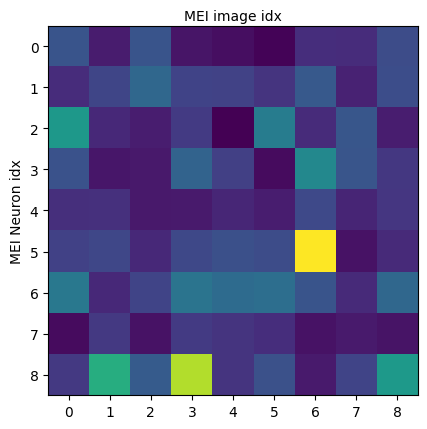

In [168]:
plt.imshow(respmat_MEI_trunc_mean)
plt.xlabel('MEI image idx')
plt.ylabel('MEI Neuron idx')
plt.xticks(np.arange(respmat_MEI_trunc_mean.shape[1])) # set for number of columns, which are the count of x axis
plt.yticks(np.arange(respmat_MEI_trunc_mean.shape[0])) # set for number of rows, which are the count of y axis
plt.gca().xaxis.set_label_position('top')
plt.show()